In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
IMAGES_PATH = r'E:\Jupyter\handson-ml2\images\classification'

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 一、MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y=mnist['data'],mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


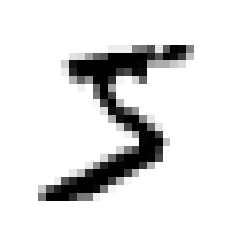

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y=y.astype(np.uint8)
y[0]

5

Saving figure more_digits_plot


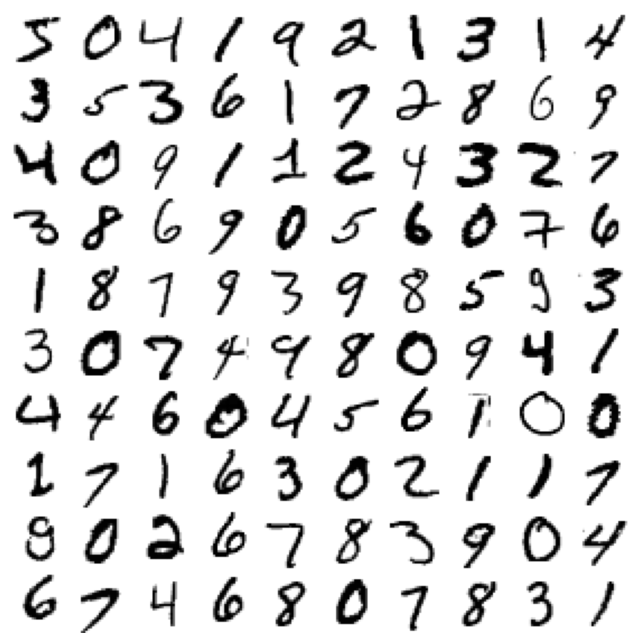

In [6]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=mpl.cm.binary,interpolation='nearest')
    plt.axis('off')
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))#数组合并
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images=X[:100]
plot_digits(example_images,images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [7]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# 二、训练二元分类器
现在先简化问题，只尝试识别一个数字，比如数字5.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 三、性能测量

## 1.使用交叉验证测量准确率

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf,X_train,y_train_5,scoring='accuracy',cv=3)
scores

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

这说明准确率无法成为分类器的首要性能指标，特别是处理有偏数据集时。

## 2.混淆矩阵

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

$混淆矩阵=
\left[
\begin{matrix}
TN(真负) & FP(假正)&\\
FN(假负) & TP(真正)&\\
\end{matrix}
\right](行表示实际类别，列表示预测类别)
$



## 3.精度和召回率
$P(精度或查准率)=\frac{TP}{TP+FP}$

$R(召回率或查全率)=\frac{TP}{TP+FN}$

$F_1=\frac{2}{\frac{1}{P}+\frac{1}{R}}=\frac{2·P·R}{P+R}=\frac{2TP}{2TP+FN+FP}$

In [16]:
from sklearn.metrics import precision_score,recall_score,f1_score

print(precision_score(y_train_5,y_train_pred))
print(3530/(3530+687))
print(recall_score(y_train_5,y_train_pred))
print(3530/(3530+1891))
print(f1_score(y_train_5,y_train_pred))
print(7060/(7060+1891+687))

0.8370879772350012
0.8370879772350012
0.6511713705958311
0.6511713705958311
0.7325171197343846
0.7325171197343847


## 4.精度/召回率权衡


决策边界<font size=4>$\theta·x_b=0→\theta·x_b=threshold$</font>(阈值)
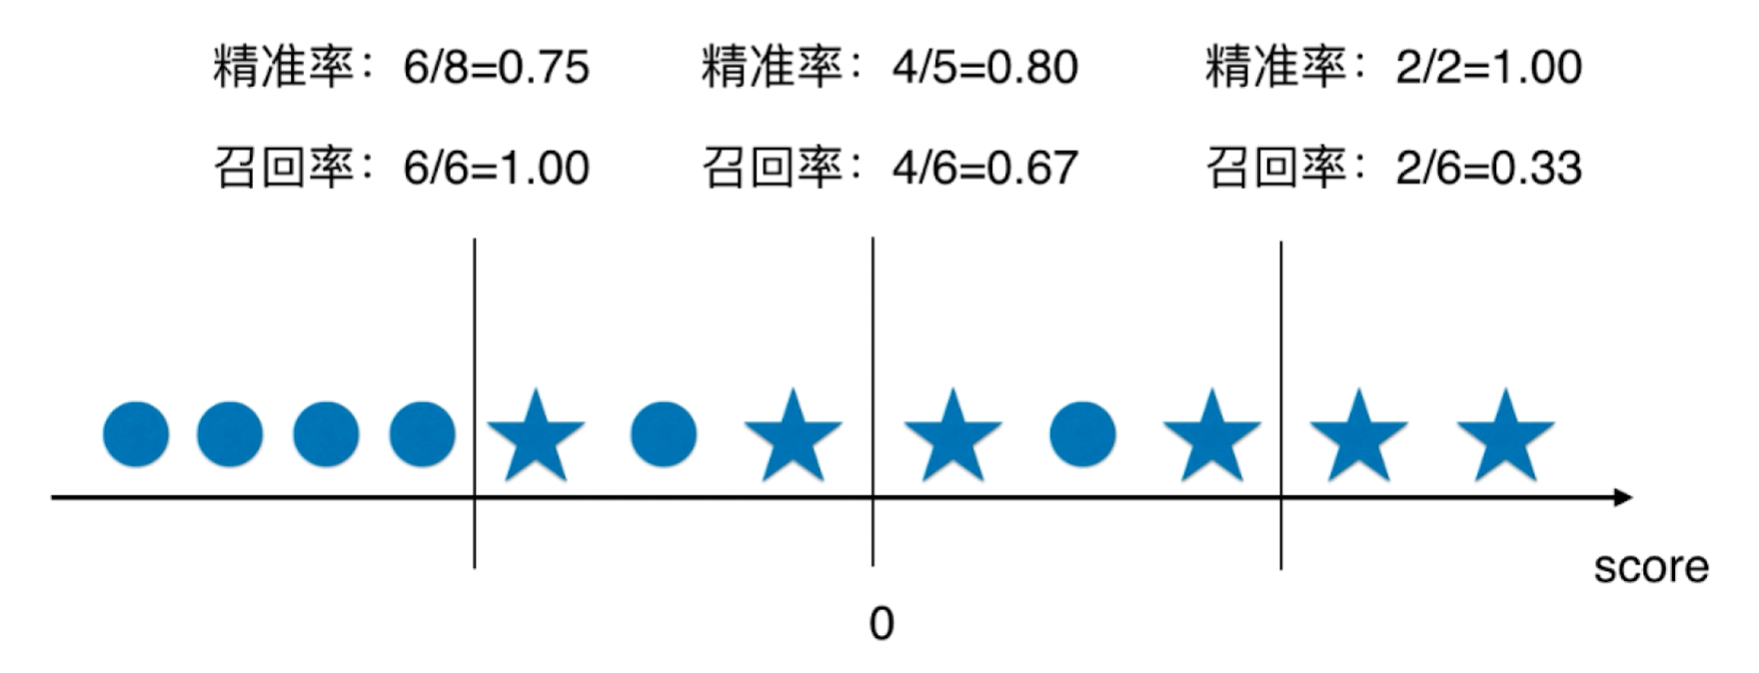
Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决策分数。不是调用分类器的`predict()`方法，而是调用`decision_function()`方法，这种方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测了。

通常，阈值越高，召回率越低，但是精度越高。

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier分类器使用的阈值是0，所以前面代码的返回结果与predict()方法一致，我们来试试提升阈值。

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

要决定阈值，首先要使用`cross_val_predict()`函数获取训练集中所有实例的分数，但是这次要返回的是决策分数而不是预测结果。

有了这些分数，就可以使用`precision_recall_curve()`函数来计算所有可能的阈值的精度和召回率。

In [20]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

Saving figure precision_recall_vs_threshold_plot


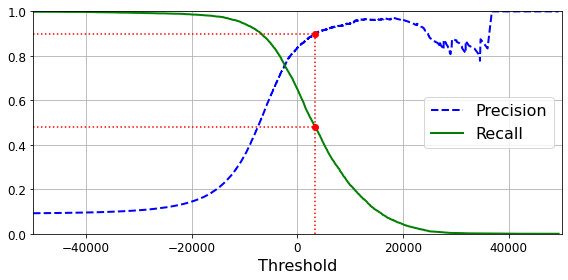

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


#np.argmax(precisions >= 0.90)即最早使precisions>=0.90的索引值
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot(threshold_90_precision, 0.9, "ro")                                             # Not shown
plt.plot(threshold_90_precision, recall_90_precision, "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


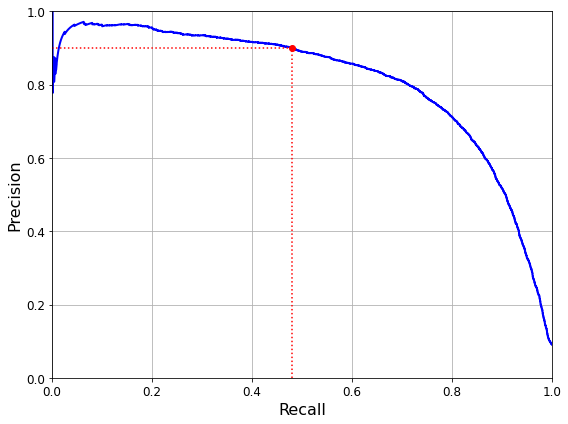

In [22]:
 def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4799, 0.4799], [0., 0.9], "r:")
plt.plot([0.0, 0.4799], [0.9, 0.9], "r:")
plt.plot([0.4799], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [23]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
recall_90_precision

0.4799852425751706

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 5.ROC曲线（受试者工作特征曲线）
描述的是真正率TPR（召回率）与假正率FPR之间的关系,是反映灵敏度(召回率)和(1-特异度)连续变量的综合指标，ROC曲线上每个点反映着对同一信号刺激的感受性。

$TPR=\frac{TP}{TP+FN}$

$FPR=\frac{FP}{FP+TN}$

In [27]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)
#使用roc_curve()函数计算多种阈值的TPR和FPR

Saving figure roc_curve_plot


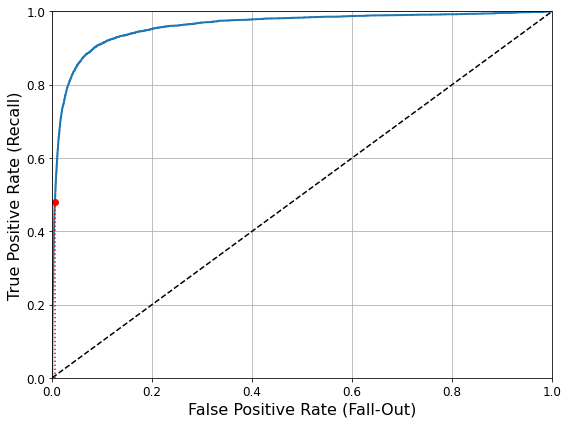

In [28]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1,0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  
    
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([5e-3, 5e-3], [0., 0.4799], "r:") 
plt.plot([0,5e-3],[0.4799,0.4799],"r:")
plt.plot([5e-3],[0.4799],"ro")
save_fig("roc_curve_plot")
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [30]:
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_sgd)

0.8370879772350012

In [31]:
recall_score(y_train_5, y_train_pred_sgd)

0.6511713705958311

PS：当正类非常少见或者你更关注假正FP类而不是假负类FN时，应该选择PR曲线，否则应选择ROC曲线。例如，看前面的ROC曲线图（以及ROC AUC分数），我们可能会觉得分类器不错，但这主要是因为跟负类（非5）相比，正类（数字5）的数量真的很少。相比之下，PR曲线清楚地说明分类器还有改进的空间（**曲线还可以更接近左上角**）。

现在来训练一个`RandomForestClassifier`分类器。由于工作方式不同，该类没有`decision_function()`方法，而是有`dict_proba()`方法，该方法会返回一个数组，其中每行代表一个实例，每列代表一个类别，意思是某个给定实例属于某个给定类别的概率（例如，这张图片有70%的可能是数字5）

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [33]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [34]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


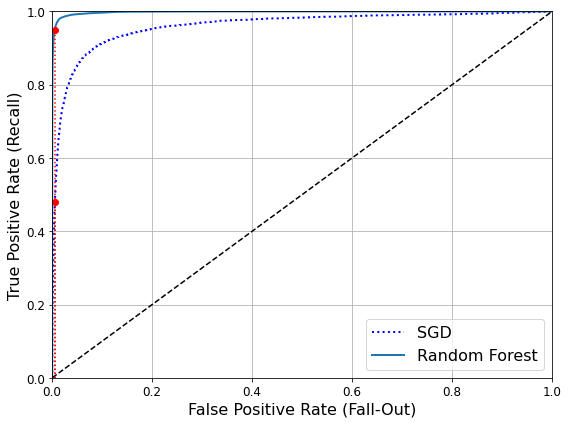

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4799], "r:")
plt.plot([0.0, 4.837e-3], [0.4799, 0.4799], "r:")
plt.plot([4.837e-3], [0.4799], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [39]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 四、多类分类器

有一些算法（如随机森林分类器或朴素贝叶斯分类器）可以直接处理多个类，也有一些严格的二元分类器（如支持向量机分类器或线性分类器）。但是，有多种策略可以让你用几个二元分类器实现多类分类的目的。

要创建一个系统将数字图片分为10类(0-9)，一种方法是训练10个二元分类器，每个数字一个（0-检测器，1-检测器...以此类推）。然后，当你需要对一张图片进行检测分类时，获取每个分类器的决策分数，哪个分类器给分最高，就将其分为哪个类。这成为一对剩余(OvR)策略。

另一种方法是为每一对数字训练一个二元分类器：一个区分0和1，一个区分0和2，一个区分1和2，以此类推。这称为一对一(OvO)策略。若存在N个类别，那么这需要训练$\frac{N×(N-1)}{2}$个分类器。对于MNIST问题，这意味着要训练45个二元分类器。OvO的主要优点在于，每个分类器只需要用到部分训练集对其必须区分的两个类进行训练。

有些算法（例如支持向量机分类器）在数据规模扩大时表现糟糕。对于这类算法，OvO是一个优先的选择，因为在较小训练集上分别训练多个分类器比在大型数据集上训练少数分类器要快得多。但是对于大部分二元分类器而言，OvR策略还是更好的选择。

Scikit-Learn可以检测到你尝试使用二元分类算法进行多类分类任务，它会根据情况自动运行OvR或OvO。

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [42]:
np.argmax(some_digit_scores)

5

In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm_clf.classes_[5]

5

本例中SVM分类器使用的是OVO策略，若想要强制Scikit-Learn使用OvR或OvO策略，可以使用`OneVsOneClassifier`或`OneVsRestClassifier`类。只需创建一个实例，然后将分类器传给其构造函数（它甚至不必是二元分类器）。例如，下面这段代码使用OvR策略，基于SVC创建了一个多类分类器：

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
ovr_clf.estimators_

[SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42)]

In [47]:
len(ovr_clf.estimators_)

10

训练`SGDClassifier`或者`RandomForestClassifier`同样简单

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 五、误差分析

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Saving figure confusion_matrix_plot2


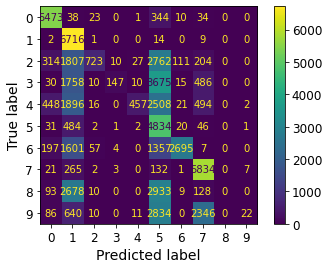

In [53]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(sgd_clf, X_train_scaled, y_train)
save_fig("confusion_matrix_plot2", tight_layout=False)
plt.show()

Saving figure confusion_matrix_plot


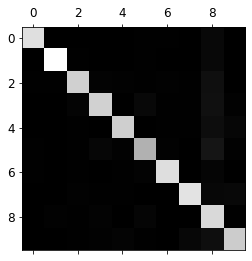

In [54]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Saving figure confusion_matrix_errors_plot


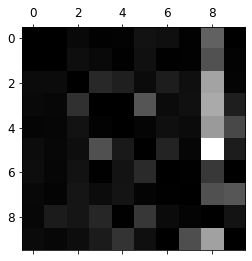

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)#每个实例的总数
norm_conf_mx = conf_mx / row_sums#每个实例被预测为另一个实例的概率

np.fill_diagonal(norm_conf_mx, 0)#只关注被错误分类的实例
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


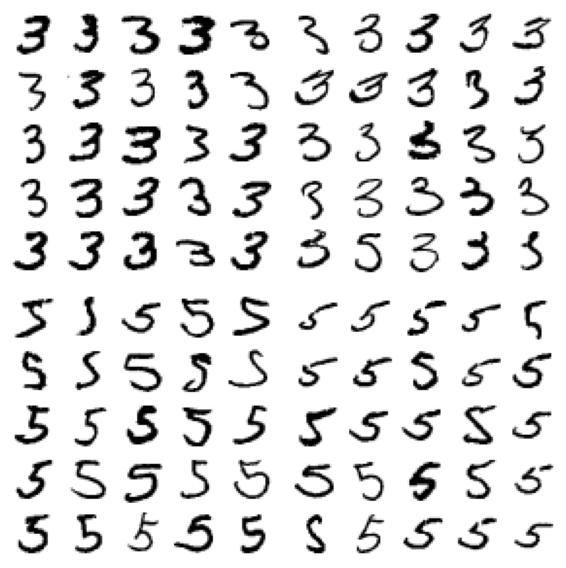

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 六、多标签分类

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train[:5000], y_multilabel[:5000], cv=3)
f1_score(y_multilabel[:5000], y_train_knn_pred[:5000], average="macro")

0.9459349842547329

# 七、多输出分类

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


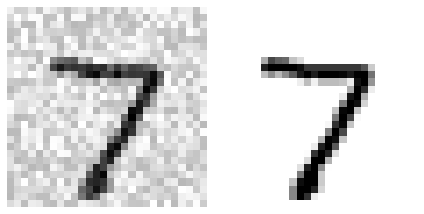

In [61]:
some_index = 0
plt.subplot(121); 
plot_digit(X_test_mod[some_index])
plt.subplot(122); 
plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


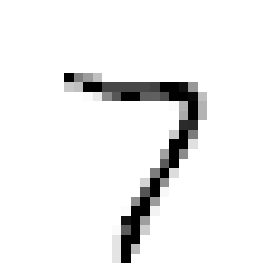

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# 八、练习题
## 1.
为MNIST数据集构建一个分类器，并在测试集上达成超过97%的准确率。

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights':['uniform','distance'],'n_neighbors':[3,4,5,6]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf,param_grid,cv=5,verbose=3)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=11.2min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.2min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=11.3min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.5min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=11.3min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.2min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=12.2min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=11.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=11.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=11.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=11.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 1532.0min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [68]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [69]:
grid_search.best_score_

0.9716166666666666

In [70]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2.
写一个可以将MNIST图片向任意方向移动一个像素的功能，然后对训练集中的每张图片，创建四个位移后的副本，添加到训练集。

In [71]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

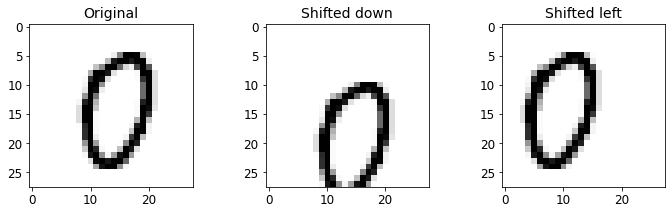

In [72]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [73]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763